# Exploratoration of a neural signal

This notebook uses an example voltage trace (exampledata.npy) of a neural signal to demonstrate some simple analysis of neural signals. The analyses include:

1. Visualize the voltage fluctuations
2. Calculate and plot power spectrum
3. Calculate and plot the time-frequency profile ("spectrogram")
4. Filter the signal (low, high, and band-pass filters)
5. Amplitude envelope of an oscillation
6. Phase time series of an oscillation

### Default imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

### Load data

In [2]:
x = np.load('./exampledata.npy') # voltage series

### Generate time axis

In [3]:
Fs = 1000. # sampling rate
t = np.arange(0,len(x)/Fs,1/Fs) # time array

# 1. Plot time series

(9, 10.5)

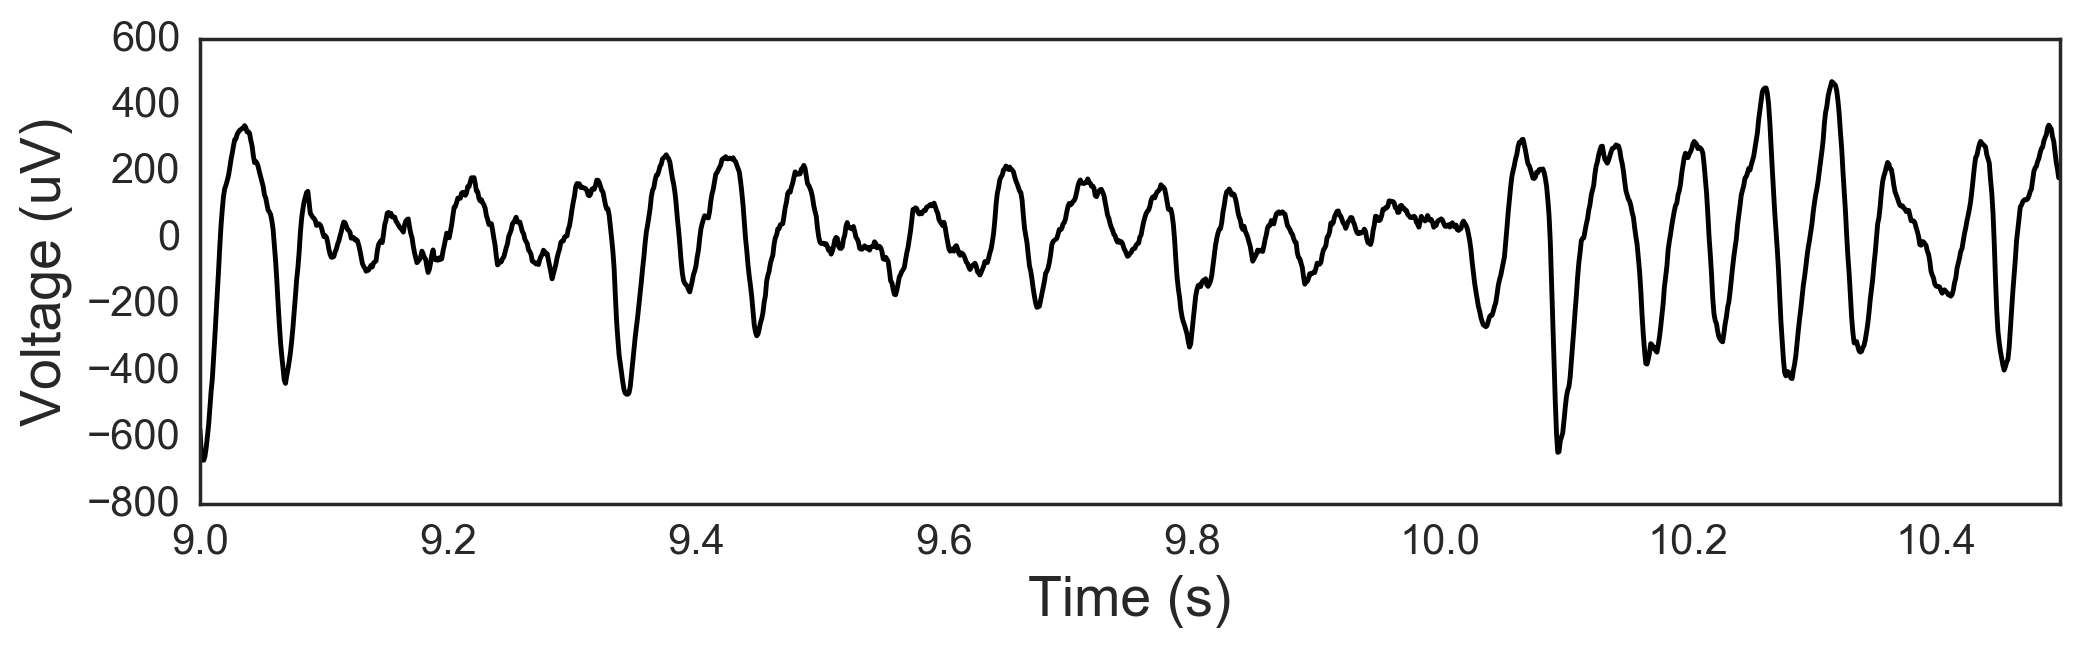

In [4]:
t_plot = [9,10.5]
t_plot_idx = np.where(np.logical_and(t>=t_plot[0],t<t_plot[1]))[0]
plt.figure(figsize=(12,3))
plt.plot(t[t_plot_idx], x[t_plot_idx],'k')
plt.yticks(size=15)
plt.xticks(size=15)
plt.xlabel('Time (s)',size=20)
plt.ylabel('Voltage (uV)',size=20)
plt.xlim((t_plot))

# 2. Power spectral density (PSD)

In [5]:
# Calculate the psd
from scipy import signal
f, psd = sp.signal.welch(x, Fs, nperseg=1000)

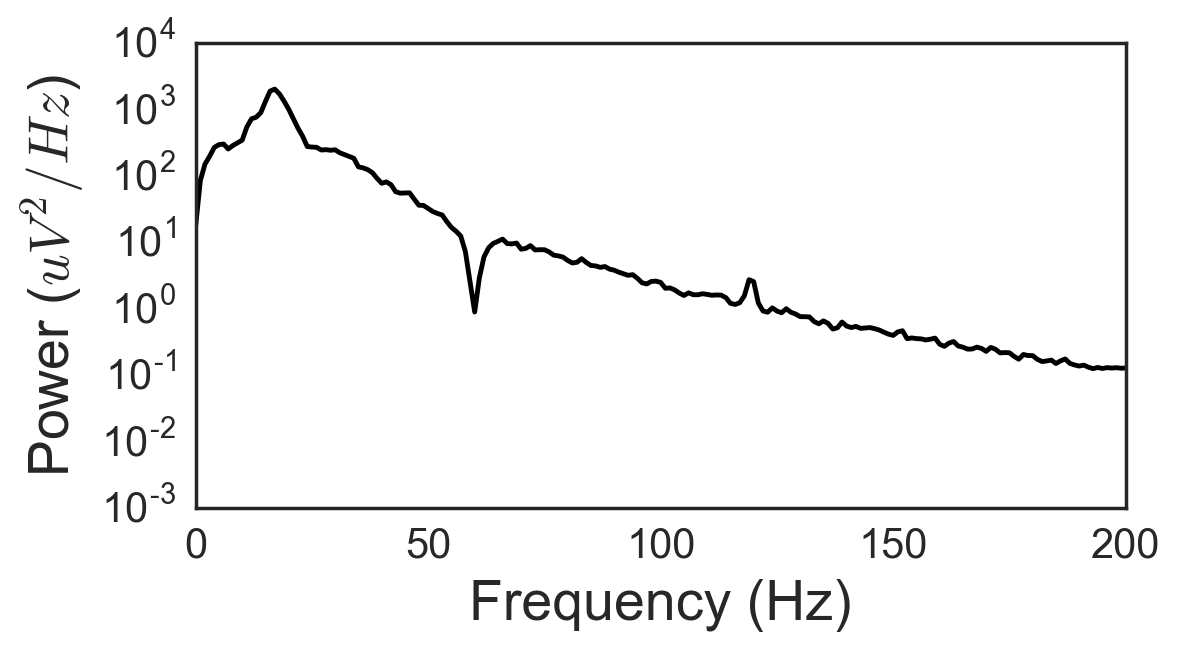

In [6]:
# Plot the power spectrum
plt.figure(figsize=(6,3))
plt.semilogy(f,psd,'k')
plt.xlim((0,200))
plt.yticks(size=15)
plt.xticks(size=15)
plt.ylabel('Power ($uV^{2}/Hz$)',size=20)
plt.xlabel('Frequency (Hz)',size=20)

# 3. Calculate and plot the time-frequency profile ("spectrogram")

In [7]:
# Only use data in a certain range
samp_spec = range(10000,20000)

# Calculate spectrogram of data in limited range
f, t_spec, x_spec = sp.signal.spectrogram(x[samp_spec], fs=Fs, window='hanning', nperseg=1000, noverlap=1000-1, mode='psd')

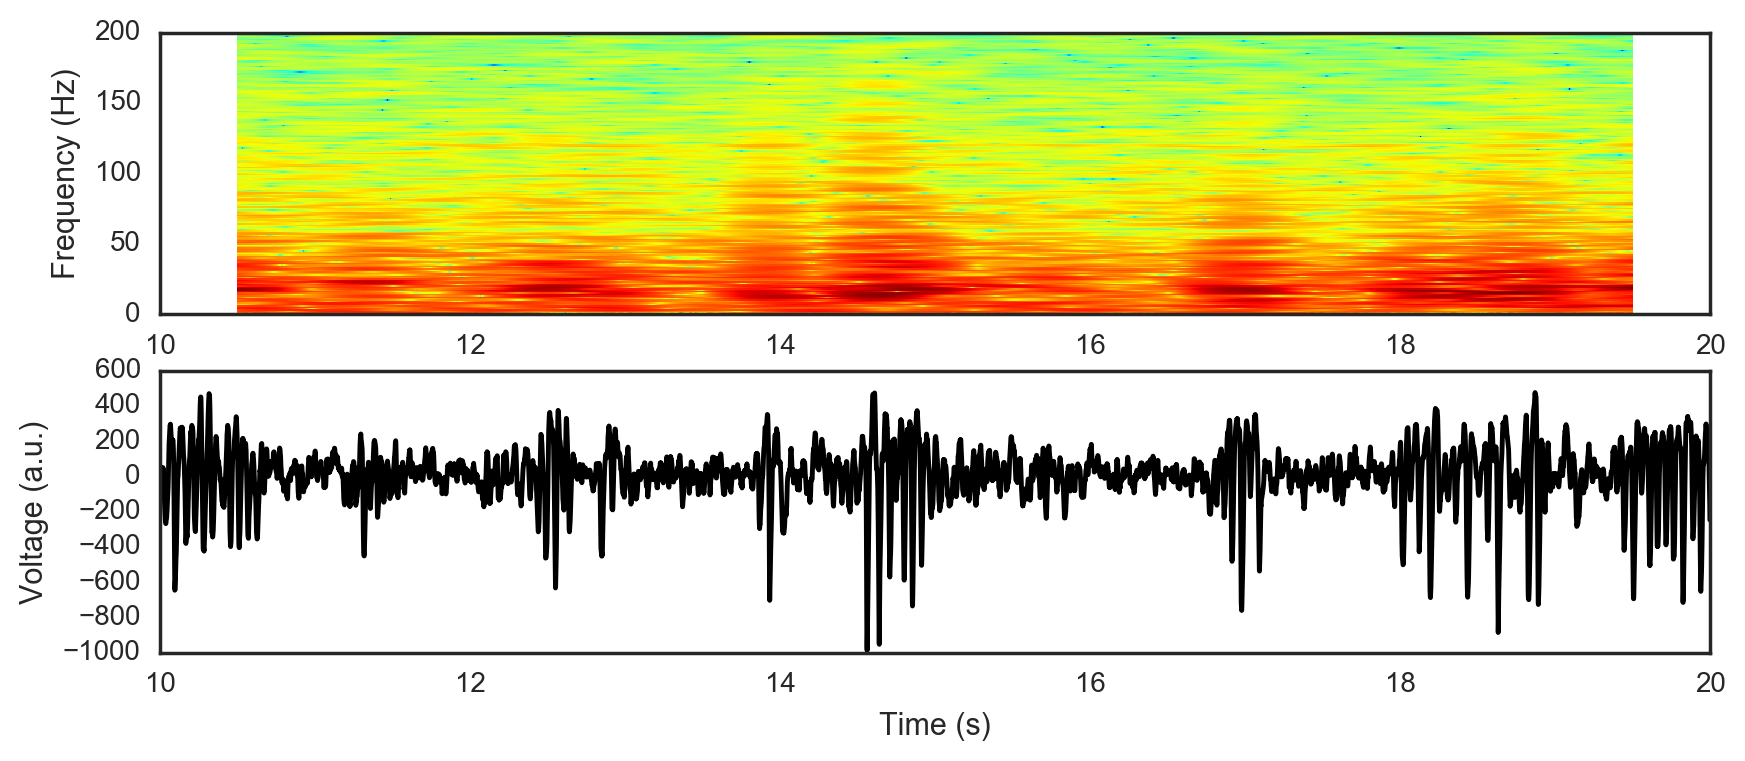

In [8]:
# Plot spectrogram
from matplotlib import cm
fmax = 200

x_mesh, y_mesh = np.meshgrid(t_spec, f[f<fmax])
plt.figure(figsize=(10,4))
plt.subplot(2,1,1)
plt.pcolormesh(x_mesh+t[samp_spec[0]], y_mesh, np.log10(x_spec[f<fmax]), cmap=cm.jet)#, vmin=vmin, vmax=vmax)
plt.ylabel('Frequency (Hz)')
#plt.colorbar()

plt.subplot(2,1,2)
plt.plot(t[samp_spec],x[samp_spec],'k')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (a.u.)')

# 4. Filter the signal

## 4a. Bandpass filter

In [15]:
def bandpass_default(x, f_range, Fs, rmv_edge = True, w = 3):
    """
    Default bandpass filter
    
    Parameters
    ----------
    x : array-like 1d
        voltage time series
    f_range : (low, high), Hz
        frequency range for narrowband signal of interest
    Fs : float
        The sampling rate
    rmv_edge : bool
        if True, remove edge artifacts
    w : float
        Length of filter order, in cycles. Filter order = ceil(Fs * w / f_range[0])
        
    Returns
    -------
    x_filt : array-like 1d
        filtered time series
    taps : array-like 1d
        filter kernel
    """
    
    # Default Ntaps as w if not provided
    Ntaps = np.ceil(Fs*w/f_range[0])
    
    # Force Ntaps to be odd
    if Ntaps % 2 == 0:
        Ntaps = Ntaps + 1
    
    # Compute filter
    taps = sp.signal.firwin(Ntaps, np.array(f_range) / (Fs/2.), pass_zero=False)
    
    # Apply filter
    x_filt = np.convolve(taps,x,'same')
    
    # Remove edge artifacts
    N_rmv = int(Ntaps/2.)
    if rmv_edge:
        return x_filt[N_rmv:-N_rmv], Ntaps
    else:
        return x_filt, taps

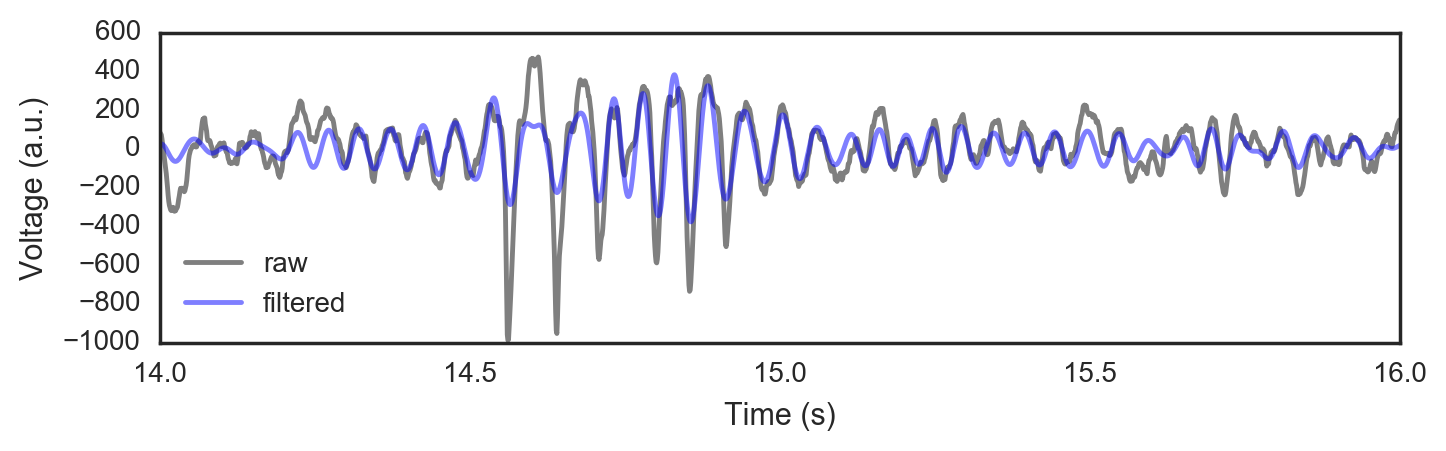

In [16]:
# Bandpass filter the signal in the "beta frequency" range (15-25Hz)
x_filt, bp_filt = bandpass_default(x,(15,25), Fs, rmv_edge=False)

# Visualize the result of that filter
samp_plot = range(14000,16000)
plt.figure(figsize=(8,2))
plt.plot(t[samp_plot],x[samp_plot],'k',label='raw',alpha=.5)
plt.plot(t[samp_plot],x_filt[samp_plot],'b',label='filtered',alpha=.5)
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (a.u.)')

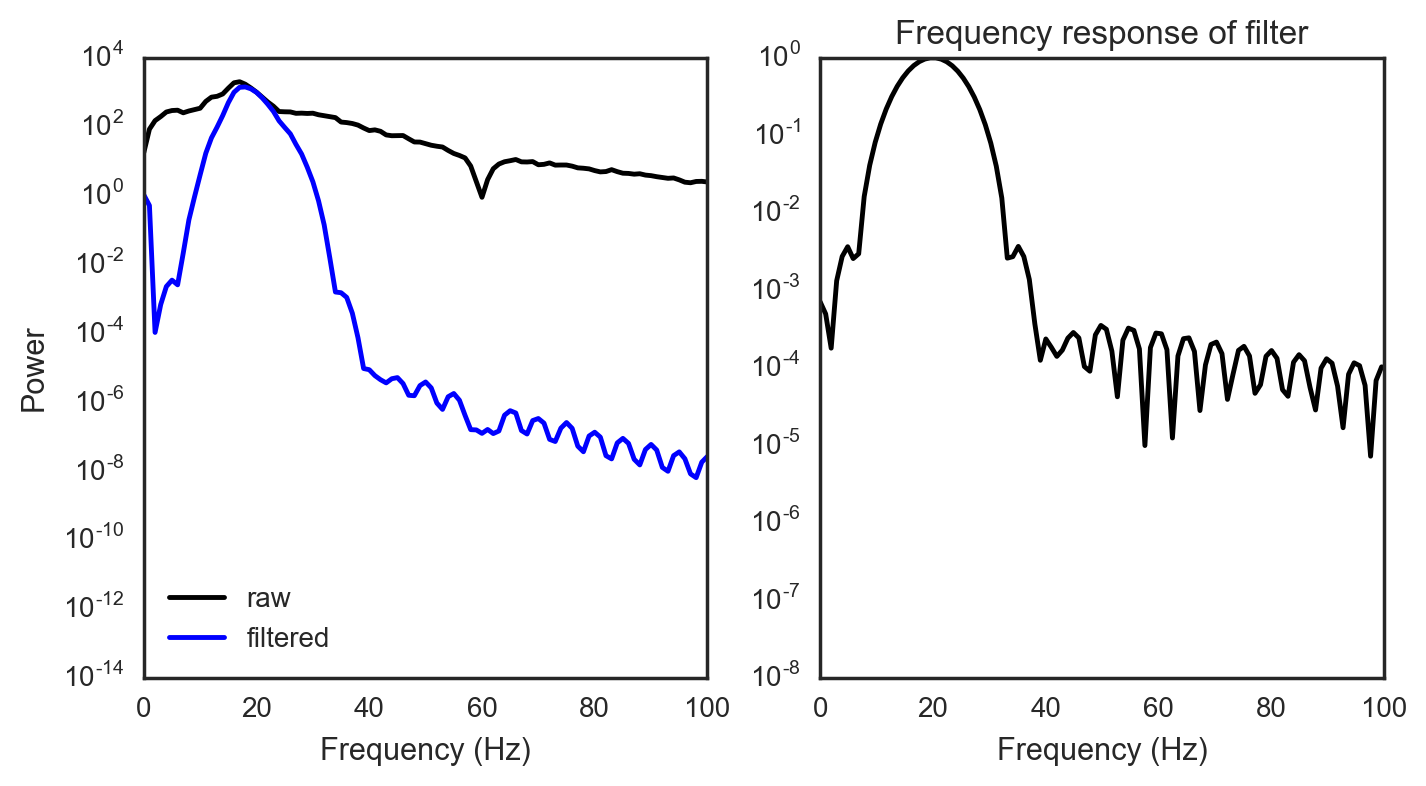

In [17]:
# Visualize the change in power spectra

# Calculate frequency response of the filter
w, h = signal.freqz(bp_filt)
f_bp = w/np.pi * Fs / 2.
amp_bp = abs(h)

# Calculate PSD of the filtered signal
f_filt, psd_filt = sp.signal.welch(x_filt, Fs, nperseg=1000)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.semilogy(f,psd,'k',label='raw')
plt.semilogy(f_filt,psd_filt,'b',label='filtered')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xlim((0,100))
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.semilogy(f_bp,amp_bp,'k')
plt.title('Frequency response of filter')
plt.xlim((0,100))
plt.xlabel('Frequency (Hz)')

## 3b. Notch filter

In [18]:
def notch_default(x, cf, bw, Fs, order = 3):
    nyq_rate = Fs / 2.
    f_range = [cf - bw / 2., cf + bw / 2.]
    Wn = (f_range[0] / nyq_rate, f_range[1] / nyq_rate)
    b, a = sp.signal.butter(order, Wn, 'bandstop')
    return sp.signal.filtfilt(b, a, x), [b,a]

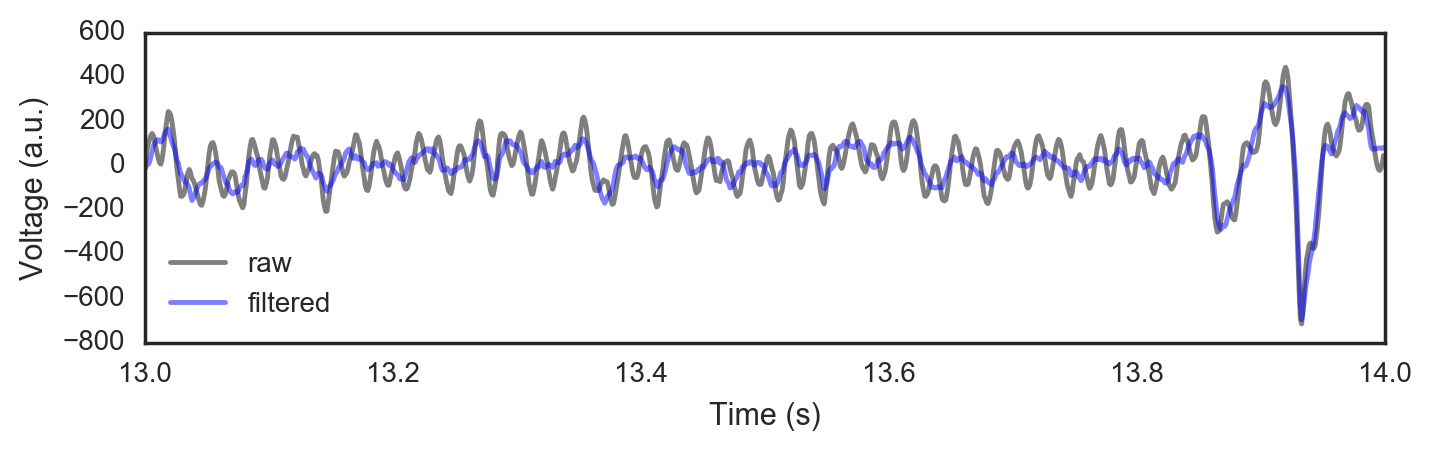

In [19]:
# Notch filter the signal at line noise frequency (60 +/- 2 Hz)
x_noise = x + np.sin(t*60*2*np.pi)*100
x_nfilt, notch_filtba = notch_default(x_noise, 60, 4, Fs)

# Visualize the result of that filter
samp_plot = range(13000,14000)
plt.figure(figsize=(8,2))
plt.plot(t[samp_plot],x_noise[samp_plot],'k',label='raw',alpha=.5)
plt.plot(t[samp_plot],x_nfilt[samp_plot],'b',label='filtered',alpha=.5)
plt.xlim((13,14))
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (a.u.)')

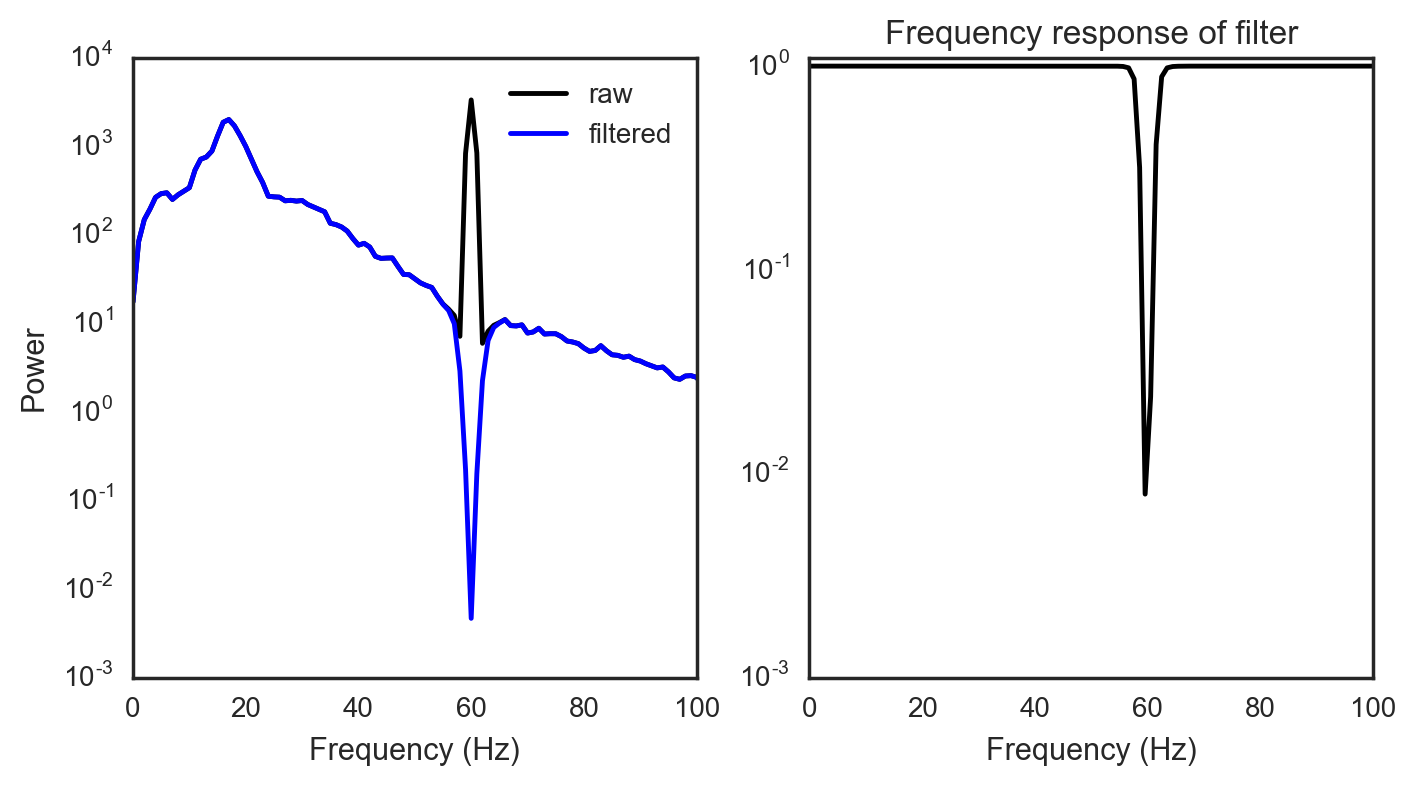

In [20]:
# Visualize the change in power spectra

# Calculate frequency response of the filter
w, h = signal.freqz(notch_filtba[0],notch_filtba[1])
f_no = w/np.pi * Fs / 2.
amp_no = abs(h)

# Calculate PSD of noise-corrupted signal
f_noise, psd_noise = sp.signal.welch(x_noise, Fs, nperseg=1000)


# Calculate PSD of the filtered signal
f_filt, psd_filt = sp.signal.welch(x_nfilt, Fs, nperseg=1000)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.semilogy(f_noise,psd_noise,'k',label='raw')
plt.semilogy(f_filt,psd_filt,'b',label='filtered')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xlim((0,100))
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.semilogy(f_no,amp_no,'k')
plt.title('Frequency response of filter')
plt.xlim((0,100))
plt.ylim((.001,1.1))
plt.xlabel('Frequency (Hz)')

# 5. Amplitude envelope of an oscillation

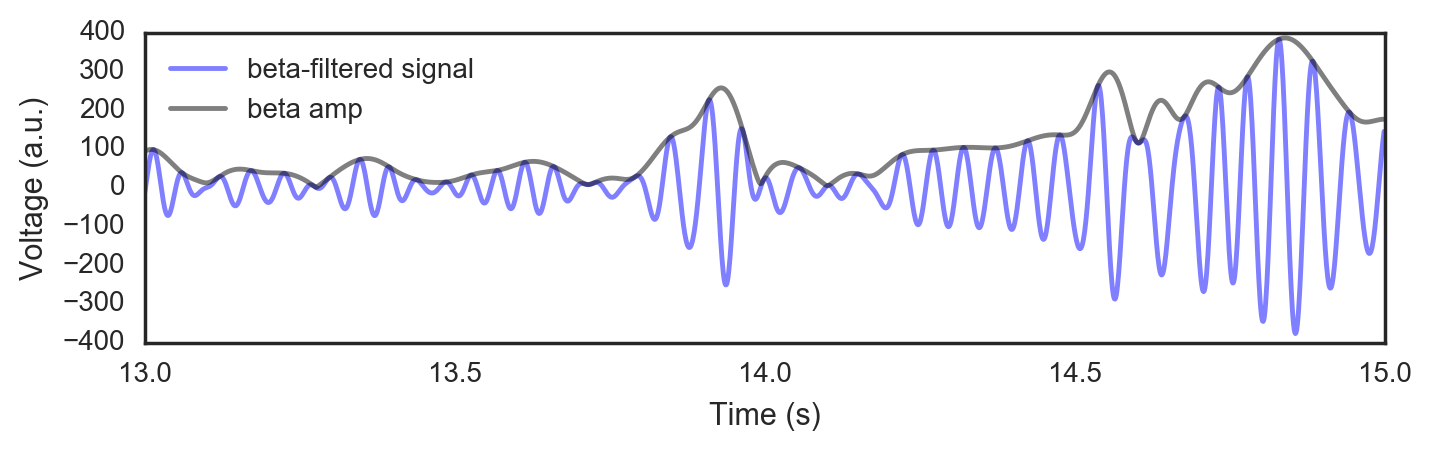

In [21]:
beta_amp = np.abs(sp.signal.hilbert(x_filt))

samp_plot = range(13000,15000)
plt.figure(figsize=(8,2))
plt.plot(t[samp_plot],x_filt[samp_plot],'b',label='beta-filtered signal',alpha=.5)
plt.plot(t[samp_plot],beta_amp[samp_plot],'k',label='beta amp',alpha=.5)
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (a.u.)')

# 6. Phase time series of an oscillation

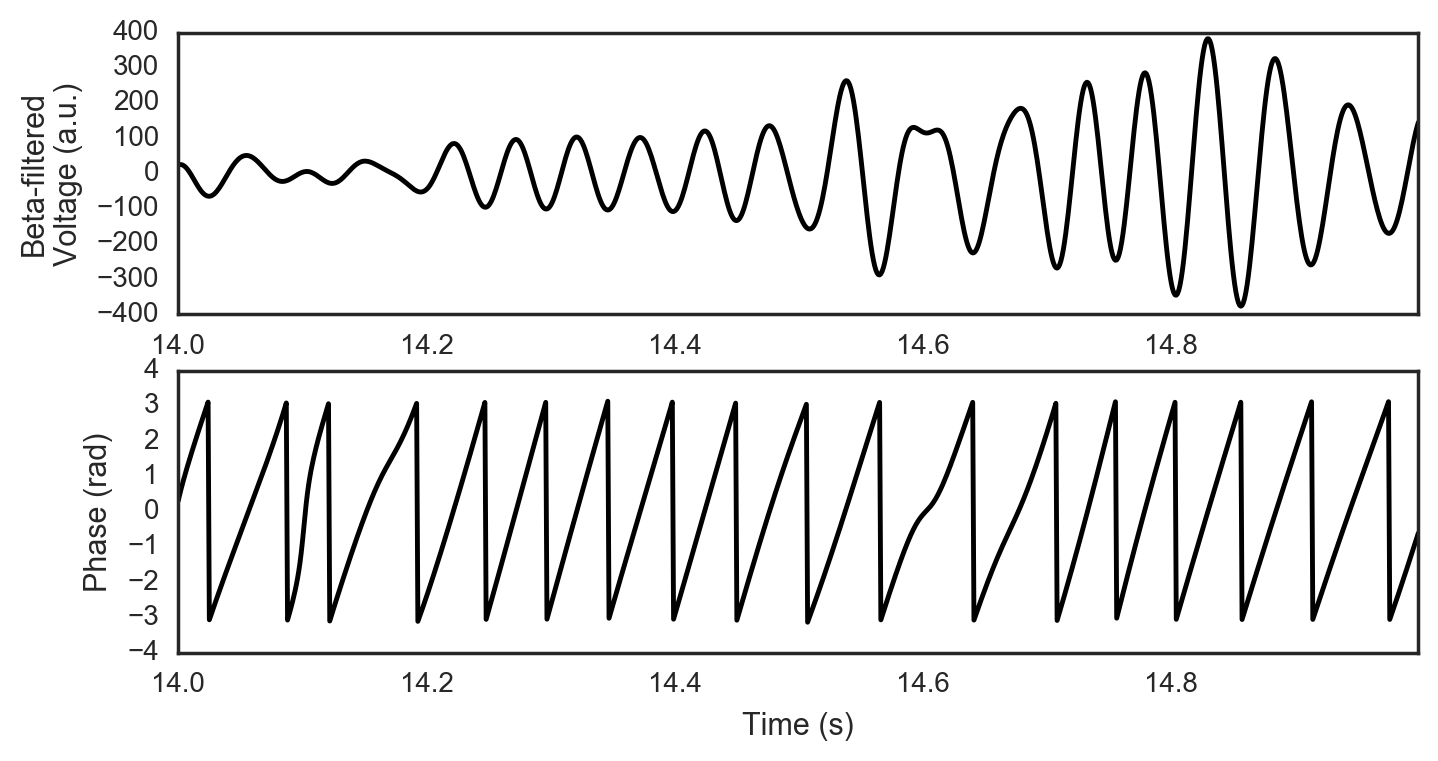

In [22]:
beta_phase = np.angle(sp.signal.hilbert(x_filt))

samp_plot = range(14000,15000)
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.plot(t[samp_plot],x_filt[samp_plot],'k')
plt.xlim((t[samp_plot[0]],t[samp_plot[-1]]))
plt.ylabel('Beta-filtered\nVoltage (a.u.)')
plt.subplot(2,1,2)
plt.plot(t[samp_plot],beta_phase[samp_plot],'k')
plt.xlim((t[samp_plot[0]],t[samp_plot[-1]]))
plt.xlabel('Time (s)')
plt.ylabel('Phase (rad)')